In [70]:
import math
import numpy as np
import os
import matplotlib.pyplot as plt

from openfold.utils.script_utils import load_models_from_command_line, parse_fasta, run_model, prep_output, \
    update_timings, relax_protein

from openfold.data import templates, feature_pipeline, data_pipeline

import pickle
import random
import time
import torch

from openfold.config import model_config
from openfold.np import residue_constants, protein
from openfold.utils.tensor_utils import (
    tensor_tree_map,
)

def round_up_seqlen(seqlen):
    return int(math.ceil(seqlen / TRACING_INTERVAL)) * TRACING_INTERVAL

In [71]:
protein_name = 'T1133' #'T1110'

with open(f"./pkls/{protein_name}.pkl", "rb") as f:
    feature_dict = pickle.load(f)
    #print(feature_dict)
tag = protein_name
device = "cuda:0"
config_preset = "model_1"
trace_model = False
output_dir = os.getcwd()
multimer_ri_gap = 200
subtract_plddt = False
cif_output = True
output_name = f"./{protein_name}_of"

config = model_config("model_1_ptm", long_sequence_inference="store_true")

model_name = 'finetuning_ptm_2'
model_generator = load_models_from_command_line(
    config,
    "cuda:0",
    f"openfold/resources/openfold_params/{model_name}.pt",
    None,
    "./")

feature_processor = feature_pipeline.FeaturePipeline(config.data)

In [72]:
for model, output_directory in model_generator:
    cur_tracing_interval = 0
    processed_feature_dict = feature_processor.process_features(
        feature_dict, mode='predict',
    )

    processed_feature_dict = {
        k:torch.as_tensor(v, device=device)
        for k,v in processed_feature_dict.items()
    }

    if(trace_model):
        if(rounded_seqlen > cur_tracing_interval):
            logger.info(
                f"Tracing model at {rounded_seqlen} residues..."
            )
            t = time.perf_counter()
            trace_model_(model, processed_feature_dict)
            tracing_time = time.perf_counter() - t
            logger.info(
                f"Tracing time: {tracing_time}"
            )
            cur_tracing_interval = rounded_seqlen

    out = run_model(model, processed_feature_dict, tag, output_dir)



    

INFO:/raid/wlqor98/ano/openfold/openfold/utils/script_utils.py:Loaded OpenFold parameters at openfold/resources/openfold_params/finetuning_ptm_2.pt...
INFO:/raid/wlqor98/ano/openfold/openfold/utils/script_utils.py:Running inference for T1133...
INFO:/raid/wlqor98/ano/openfold/openfold/utils/script_utils.py:Inference time: 360.96411010799056


In [73]:

# 여러 모델을 사용해서 best result를 고를 수 있음. 단 아래의 세팅에서는 한가지 모델에 대해서만 작업을 수행함. 
prediction_result = out

# Move the batch and output to np for further processing
processed_feature_dict = tensor_tree_map(
    lambda t: np.array(t[..., -1].cpu()), processed_feature_dict
)
prediction_result = tensor_tree_map(
    lambda t: np.array(t.cpu()), prediction_result
)

mean_plddt = prediction_result['plddt'].mean()

plddts = {}
unrelaxed_proteins = {}
plddts[model_name] = prediction_result['plddt']

# Set the b-factors to the per-residue plddt.
final_atom_mask = prediction_result['final_atom_mask']
b_factors = prediction_result['plddt'][:, None] * final_atom_mask
unrelaxed_protein = protein.from_prediction(
    processed_feature_dict, prediction_result, b_factors=b_factors
)
unrelaxed_proteins[model_name] = unrelaxed_protein


# Find the best model according to the mean pLDDT.
best_model_name = max(plddts.keys(), key=lambda x: plddts[x].mean())
best_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])



# Write out the prediction

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

pred_output_path = os.path.join(output_dir, f'{output_name}_unrelaxed.pdb')
with open(pred_output_path, 'w') as f:
    f.write(best_pdb)


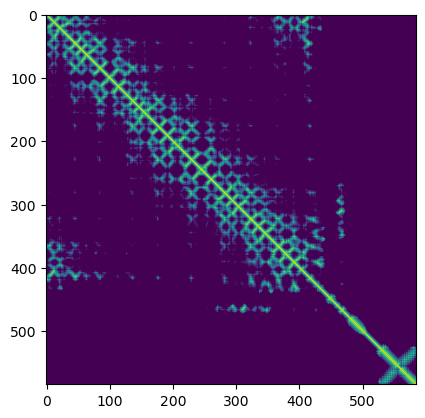

In [74]:
plt.imshow(64-out['distogram_logits'].argmax(2).cpu())
plt.show()

In [75]:
# for i in range(128):
#     plt.imshow(out["pair"][:,:,i].cpu())
#     plt.show()

# head별로 representation을 확인

In [76]:
from Bio.PDB import PDBParser

# Replace with your PDB file path
pdb_file = f"prediction/{protein_name}_of_unrelaxed.pdb"

# Initialize parser and parse the structure
parser = PDBParser()
structure = parser.get_structure("protein", pdb_file)

# Extract pLDDT scores
plddt_scores = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                plddt_score = atom.get_bfactor()
                plddt_scores.append(plddt_score)
                break  # Assuming all atoms in a residue have the same score

# Optionally, you can calculate the average pLDDT score
average_plddt = sum(plddt_scores) / len(plddt_scores) if plddt_scores else None

print(f"Average pLDDT Score: {average_plddt}")
print(f"All pLDDT Scores: {plddt_scores}")


# pLDDT 점수는 각 아미노산 잔기의 위치에 대한 예측의 신뢰도를 나타냅니다.

# A PDB (Protein Data Bank) file contains detailed information about the 3D structure of proteins.
# The B-factor column, which originally represents the atomic displacement or mobility, is sometimes repurposed to store pLDDT scores in PDB files generated by certain protein structure prediction tools.


Average pLDDT Score: 87.37574358974355
All pLDDT Scores: [52.43, 52.14, 64.09, 77.66, 86.91, 92.73, 95.82, 95.65, 96.75, 96.79, 96.19, 94.73, 93.44, 90.67, 93.91, 96.65, 96.24, 95.74, 95.78, 94.36, 90.86, 86.42, 87.24, 86.03, 90.78, 93.54, 93.81, 92.07, 90.42, 89.28, 91.81, 88.4, 92.13, 91.98, 84.83, 80.47, 82.39, 86.32, 89.57, 87.83, 94.98, 96.76, 97.4, 97.55, 97.2, 94.38, 95.06, 95.75, 96.2, 97.45, 97.59, 97.61, 96.78, 95.27, 91.54, 90.86, 92.84, 94.82, 97.1, 96.66, 97.18, 96.55, 95.31, 93.28, 86.08, 86.06, 85.01, 88.55, 95.49, 95.37, 96.32, 96.67, 95.62, 94.64, 93.49, 90.94, 89.86, 93.98, 94.35, 96.25, 97.41, 97.49, 97.94, 97.47, 95.75, 96.13, 96.07, 97.36, 98.14, 98.05, 97.93, 97.41, 96.32, 94.45, 92.76, 90.17, 85.52, 82.38, 73.83, 75.26, 76.75, 69.36, 73.54, 70.24, 79.65, 86.01, 91.71, 94.55, 96.85, 97.23, 98.03, 97.95, 97.52, 97.16, 95.59, 96.75, 96.44, 96.85, 96.91, 97.12, 96.6, 95.45, 94.78, 93.12, 93.58, 91.01, 89.61, 91.14, 87.09, 86.78, 93.52, 94.11, 95.23, 95.82, 96.81, 96.

/home/wlqor98/.conda/envs/openfold_venv/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4588
  warnings.warn(
